In [3]:
from typing import TypedDict, Literal, List
from langgraph.graph import StateGraph, START, END
from langchain_community.vectorstores import FAISS
from langchain_ollama import OllamaEmbeddings
from langchain_core.documents import Document
import random


In [4]:

# 1단계: 상태 정의
class RecommendationState(TypedDict):
    customer_preference: str        # 고객 취향
    recommended_menu: str           # 추천된 메뉴명
    menu_details: str              # 메뉴 상세 정보
    recommendation_reason: str      # 추천 이유

# Vector DB 초기화
embeddings_model = OllamaEmbeddings(model="bge-m3:latest")
menu_db = FAISS.load_local(
    "./db/cafe_db", 
    embeddings_model, 
    allow_dangerous_deserialization=True
)


In [5]:

# 2단계: 노드 함수들 정의

def get_customer_preference(state: RecommendationState) -> RecommendationState:
    """고객 취향을 파악하는 단계"""
    print("---고객 취향 파악---")
    preferences = ["단맛", "쓴맛", "신맛"]
    preference = random.choice(preferences)
    print(f"고객 취향: {preference}")
    
    return {"customer_preference": preference}


In [6]:

def recommend_sweet_menu(state: RecommendationState) -> RecommendationState:
    """단맛을 선호하는 고객을 위한 메뉴 추천 (Vector DB 검색)"""
    print("---단맛 메뉴 추천---")
    
    # 단맛 관련 키워드로 검색
    sweet_queries = ["바닐라", "카라멜", "달콤한", "티라미수"]
    query = random.choice(sweet_queries)
    
    # Vector DB에서 검색
    docs = menu_db.similarity_search(query, k=4)
    
    if docs:
        selected_doc = random.choice(docs)
        menu_name = selected_doc.metadata.get('menu_name', 'Unknown')
        menu_content = selected_doc.page_content
        
        reason = f"{menu_name}은(는) 달콤한 맛을 좋아하시는 고객님께 완벽한 선택입니다. Vector DB 검색을 통해 '{query}' 키워드와 가장 유사한 메뉴로 선정되었습니다."
        
        print(f"추천 메뉴: {menu_name}")
        print(f"추천 이유: {reason}")
        
        return {
            "recommended_menu": menu_name,
            "menu_details": menu_content,
            "recommendation_reason": reason
        }
    
    # 기본값
    return {
        "recommended_menu": "바닐라 라떼",
        "menu_details": "달콤한 바닐라 시럽이 들어간 라떼",
        "recommendation_reason": "달콤한 맛을 선호하는 고객님께 추천드립니다."
    }


In [7]:

def recommend_bitter_menu(state: RecommendationState) -> RecommendationState:
    """쓴맛을 선호하는 고객을 위한 메뉴 추천 (Vector DB 검색)"""
    print("---쓴맛 메뉴 추천---")
    
    # 쓴맛 관련 키워드로 검색
    bitter_queries = ["아메리카노", "콜드브루", "에스프레소", "원두"]
    query = random.choice(bitter_queries)
    
    # Vector DB에서 검색
    docs = menu_db.similarity_search(query, k=4)
    
    if docs:
        selected_doc = random.choice(docs)
        menu_name = selected_doc.metadata.get('menu_name', 'Unknown')
        menu_content = selected_doc.page_content
        
        reason = f"{menu_name}은(는) 진한 커피 맛을 좋아하시는 고객님께 완벽한 선택입니다. Vector DB 검색을 통해 '{query}' 키워드와 가장 유사한 메뉴로 선정되었습니다."
        
        print(f"추천 메뉴: {menu_name}")
        print(f"추천 이유: {reason}")
        
        return {
            "recommended_menu": menu_name,
            "menu_details": menu_content,
            "recommendation_reason": reason
        }
    
    # 기본값
    return {
        "recommended_menu": "아메리카노",
        "menu_details": "진한 에스프레소에 뜨거운 물을 더한 클래식 커피",
        "recommendation_reason": "진한 커피 맛을 선호하는 고객님께 추천드립니다."
    }


In [8]:

def recommend_sour_menu(state: RecommendationState) -> RecommendationState:
    """신맛을 선호하는 고객을 위한 메뉴 추천 (Vector DB 검색)"""
    print("---신맛 메뉴 추천---")
    
    # 신맛 관련 키워드로 검색
    sour_queries = ["녹차", "과일", "상큼한", "프라푸치노"]
    query = random.choice(sour_queries)
    
    # Vector DB에서 검색
    docs = menu_db.similarity_search(query, k=4)
    
    if docs:
        selected_doc = random.choice(docs)
        menu_name = selected_doc.metadata.get('menu_name', 'Unknown')
        menu_content = selected_doc.page_content
        
        reason = f"{menu_name}은(는) 상큼한 맛을 좋아하시는 고객님께 완벽한 선택입니다. Vector DB 검색을 통해 '{query}' 키워드와 가장 유사한 메뉴로 선정되었습니다."
        
        print(f"추천 메뉴: {menu_name}")
        print(f"추천 이유: {reason}")
        
        return {
            "recommended_menu": menu_name,
            "menu_details": menu_content,
            "recommendation_reason": reason
        }
    
    # 기본값
    return {
        "recommended_menu": "녹차 라떼",
        "menu_details": "말차 파우더와 스팀 밀크로 만든 건강한 음료",
        "recommendation_reason": "상큼한 맛을 선호하는 고객님께 추천드립니다."
    }


In [9]:

def decide_recommendation_path(state: RecommendationState) -> Literal["sweet", "bitter", "sour"]:
    """고객 취향에 따라 다음 실행할 노드를 결정하는 함수"""
    preference = state["customer_preference"]
    if preference == "단맛":
        return "sweet"
    elif preference == "쓴맛":
        return "bitter"
    else:
        return "sour"

# 3단계: 그래프 구성
builder = StateGraph(RecommendationState)

builder.add_node("get_preference", get_customer_preference)
builder.add_node("recommend_sweet", recommend_sweet_menu)
builder.add_node("recommend_bitter", recommend_bitter_menu)
builder.add_node("recommend_sour", recommend_sour_menu)

builder.add_edge(START, "get_preference")
builder.add_conditional_edges(
    "get_preference",
    decide_recommendation_path,
    {
        "sweet": "recommend_sweet",
        "bitter": "recommend_bitter",
        "sour": "recommend_sour"
    }
)
builder.add_edge("recommend_sweet", END)
builder.add_edge("recommend_bitter", END)
builder.add_edge("recommend_sour", END)

graph = builder.compile()


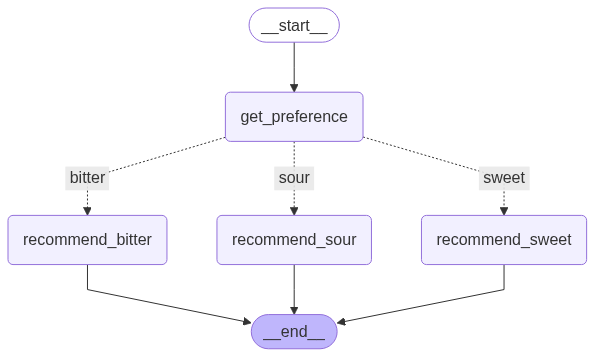

In [10]:
from IPython.display import Image, display

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:

# 4단계: 실행 및 테스트
initial_state = {
    "customer_preference": "",
    "recommended_menu": "",
    "menu_details": "",
    "recommendation_reason": ""
}

result = graph.invoke(initial_state)
print("\n=== 최종 추천 결과 ===")
print(f"고객 취향: {result['customer_preference']}")
print(f"추천 메뉴: {result['recommended_menu']}")
print(f"메뉴 상세: {result['menu_details']}")
print(f"추천 이유: {result['recommendation_reason']}")

---고객 취향 파악---
고객 취향: 쓴맛
---쓴맛 메뉴 추천---
추천 메뉴: 프라푸치노
추천 이유: 프라푸치노은(는) 진한 커피 맛을 좋아하시는 고객님께 완벽한 선택입니다. Vector DB 검색을 통해 '에스프레소' 키워드와 가장 유사한 메뉴로 선정되었습니다.

=== 최종 추천 결과 ===
고객 취향: 쓴맛
추천 메뉴: 프라푸치노
메뉴 상세: 7. 프라푸치노
   • 가격: ₩7,000
   • 주요 원료: 에스프레소, 우유, 얼음, 휘핑크림
   • 설명: 에스프레소와 우유, 얼음을 블렌더에 갈아 만든 시원한 음료입니다. 부드럽고 크리미한 질감이 특징이며, 휘핑크림을 올려 달콤함을 더했습니다. 여름철 인기 메뉴입니다.
추천 이유: 프라푸치노은(는) 진한 커피 맛을 좋아하시는 고객님께 완벽한 선택입니다. Vector DB 검색을 통해 '에스프레소' 키워드와 가장 유사한 메뉴로 선정되었습니다.
